Variational Autoencoder test

Python version: x <br>
PyTorch version: y <br>
Numpy version: z <br>

In [281]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

DEVICE = torch.device("cpu")

image_size = (16, 16)
image_vector_dim = image_size[0] * image_size[1]

object_size = (10, 10)

input_dimension = image_size[0] * image_size[1]
hidden_dimension_encoder = 10
latent_dimension = 10
hidden_dimension_decoder = 10

output_dimension = image_size[0] * image_size[1]

dataset_size = 5000
batch_size = 10
epochs = 50
learning_rate = 0.001

In [282]:
from typing import Tuple
import matplotlib.pyplot as plt

class RandomImageDataset(Dataset):
    def __init__(self, dataset_size, image_size, object_size):
        self.dataset_size = dataset_size
        self.image_size = image_size
        self.object_size = object_size

    def __len__(self) -> int:
        return self.dataset_size

    def __getitem__(self, idx: int):
        z = torch.zeros(self.image_size)
        o = torch.ones(self.object_size)

        object_x_min = 0
        object_x_max = self.image_size[0] - self.object_size[0]

        object_y_min = 0
        object_y_max = self.image_size[0] - self.object_size[0]

        object_x = np.random.randint(object_x_min, object_x_max)
        object_y = np.random.randint(object_y_min, object_y_max)

        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = o        
        return z


#dataset_test = RandomImageDataset(image_size = image_size)
#plt.imshow(dataset_test.__getitem__(123), cmap='gray')
#plt.axis('off')
#plt.title('Test image')
#plt.show()

dataset_training = RandomImageDataset(dataset_size=dataset_size, image_size=image_size, object_size=object_size)
dataset_testing = RandomImageDataset(dataset_size=dataset_size, image_size=image_size, object_size=object_size)

dataloader_training = DataLoader(dataset_training, batch_size=batch_size)
dataloader_testing = DataLoader(dataset_testing, batch_size=batch_size)

In [283]:
# Encoder
class Encoder(torch.nn.Module):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(Encoder, self).__init__()
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.latent_dimension = latent_dimension

        self.fc0 = torch.nn.Linear(input_dimension, hidden_dimension)
        self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        self.mean = torch.nn.Linear(hidden_dimension, latent_dimension)
        self.var = torch.nn.Linear(hidden_dimension, latent_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        t = self.fc1(t)
        t = self.lrelu(t)
        mean = self.mean(t)
        var = self.var(t)

        return mean, var


In [284]:
# Decoder

class Decoder(torch.nn.Module):
    def __init__(self, latent_dimension, hidden_dimension, output_dimension):
        super(Decoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

        self.fc0 = torch.nn.Linear(latent_dimension, hidden_dimension)
        self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        self.output = torch.nn.Linear(hidden_dimension, output_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)

        t = self.fc1(t)
        t = self.lrelu(t)

        t = torch.sigmoid(self.output(t))

        return t
    

In [285]:
# Model

class VariationalAutoencoder(torch.nn.Module):
    
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

        
    def forward(self, data):
        mean, var = self.encoder(data)
        e = torch.randn_like(var).to(DEVICE)
        z = mean + torch.exp(0.5* var) * e

        data_ = self.decoder(z)

        return data_, mean, var

vae = VariationalAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)
vae.to(DEVICE)

# loss

from torch.optim import Adam

def vae_loss(data, data_, mean, var):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    KLD = -0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())
    return loss + KLD
    
optimizer = Adam(vae.parameters(), lr = learning_rate)


vae.train()

for e in range(epochs):
    epoch_loss = 0

    for data in dataloader_training:
        data = data.view(batch_size, image_vector_dim)
        data = data.to(DEVICE)

        optimizer.zero_grad()

        data_, mean, var = vae(data)
        loss = vae_loss(data, data_, mean, var)
        
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    print("epoch",e," loss:", epoch_loss)

epoch 0  loss: 597873.1848754883
epoch 1  loss: 392323.79943847656
epoch 2  loss: 324203.1598815918
epoch 3  loss: 276132.8910827637
epoch 4  loss: 171560.5278930664
epoch 5  loss: 112745.6724243164
epoch 6  loss: 90110.98161315918
epoch 7  loss: 78959.10575866699
epoch 8  loss: 70975.77696990967
epoch 9  loss: 65499.425872802734
epoch 10  loss: 60647.16784667969
epoch 11  loss: 56466.71064758301
epoch 12  loss: 52448.135246276855
epoch 13  loss: 49439.45440673828
epoch 14  loss: 47052.356994628906
epoch 15  loss: 44169.88147735596
epoch 16  loss: 42822.55725860596
epoch 17  loss: 41379.58535003662
epoch 18  loss: 40682.783546447754
epoch 19  loss: 39935.20806121826
epoch 20  loss: 39434.15612030029
epoch 21  loss: 39078.375831604004
epoch 22  loss: 38262.04251098633
epoch 23  loss: 37953.33721160889
epoch 24  loss: 37673.06086730957
epoch 25  loss: 38125.17495727539
epoch 26  loss: 37056.31233215332
epoch 27  loss: 37054.03616333008
epoch 28  loss: 36677.050201416016
epoch 29  loss: 3

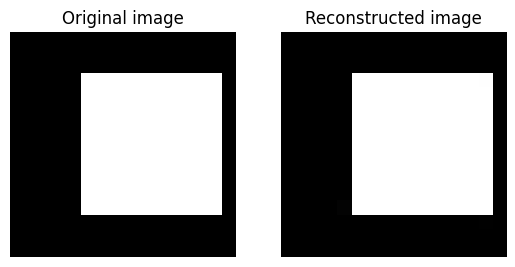

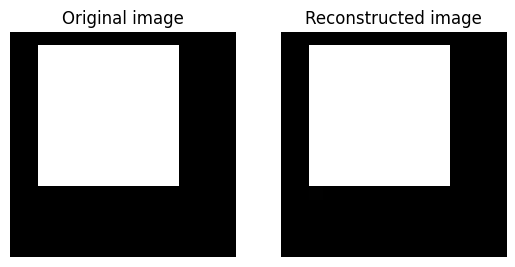

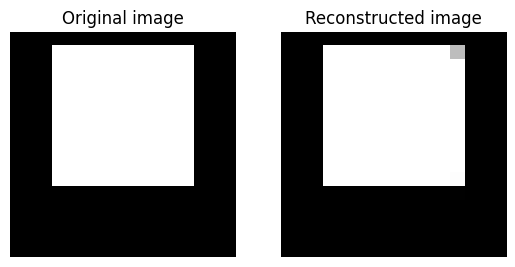

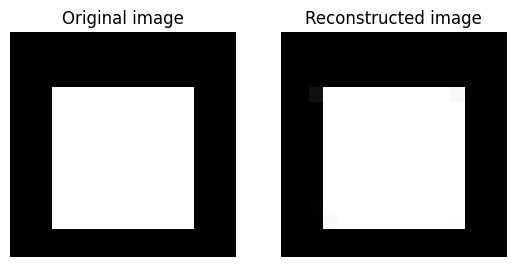

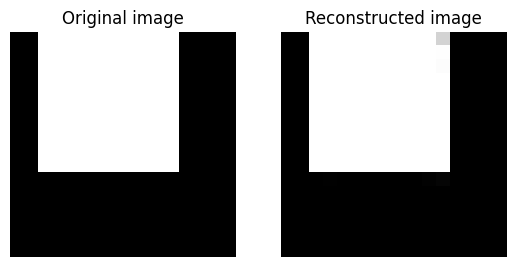

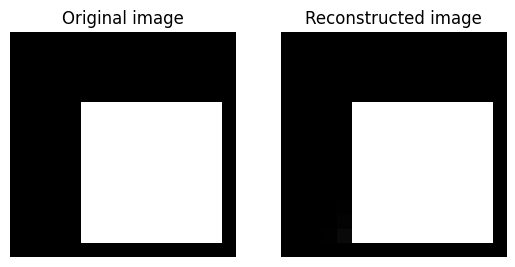

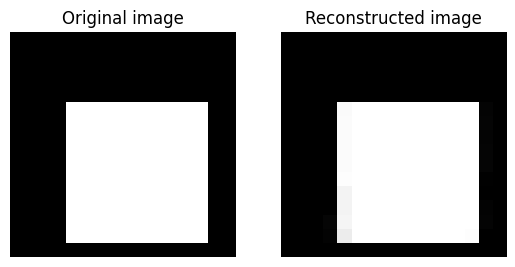

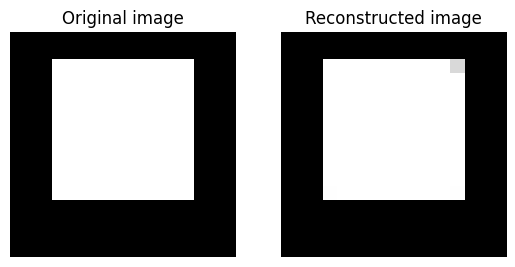

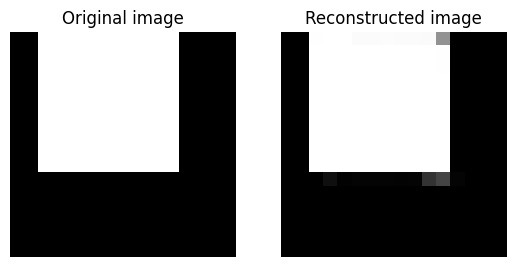

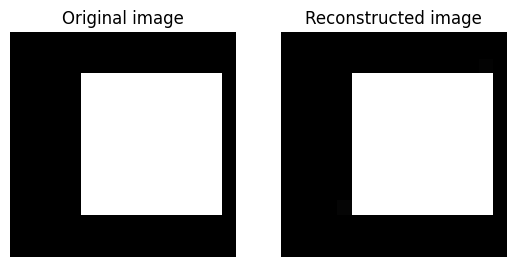

torch.Size([10, 16, 16])


In [298]:
# Visualize

vae.eval()

for data in dataloader_testing:
    data = data.view(batch_size, image_vector_dim)
    
    data=data.to(DEVICE)

    data_, mean, variance = vae(data)
    data_ = data_.view(batch_size, image_size[0], image_size[1])
    data = data.view(batch_size, image_size[0], image_size[1])
    for i in range(batch_size):
        im0 = data[i]
        im0_np = im0.cpu().detach().numpy()
        im1 = data_[i]
        im1_np = im1.cpu().detach().numpy()

        plt.subplot(1,2,1)
        plt.imshow(im0_np, cmap='gray')
        plt.axis('off')
        plt.title('Original image')
        plt.subplot(1,2,2)
        plt.imshow(im1_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed image')
        
        plt.show()
    print(data_.shape)
    break

